# Step #1 Load the Data

In [2]:
import numpy as np 
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# set file path
filepath = "data/Churn-prediction/"

# Load train and test datasets
train_df = pd.read_csv(filepath + 'telecom_churn.csv')
train_df.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


# Step #2 Create Histograms

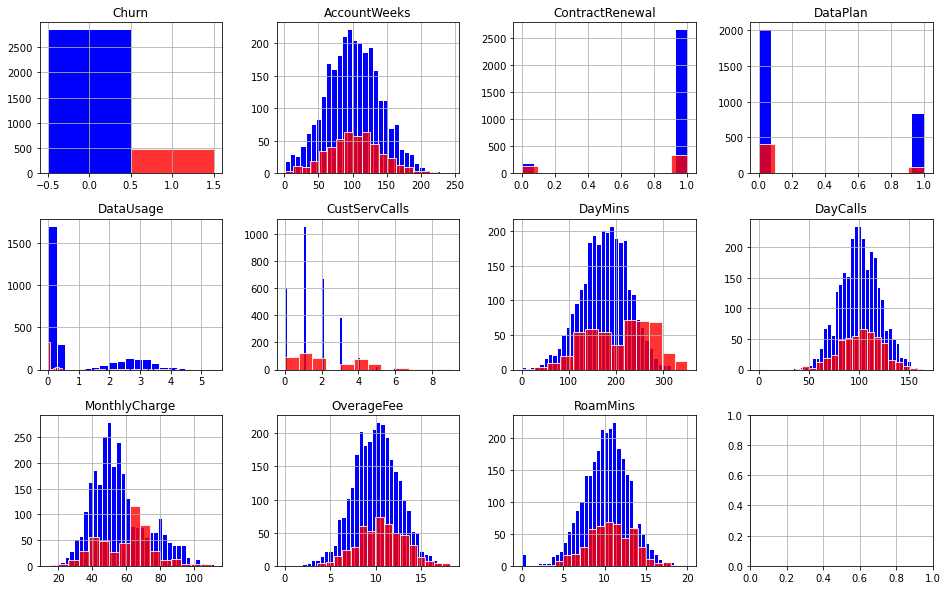

In [78]:
# Create histograms for feature columns separated by prediction label value
register_matplotlib_converters()
nrows = 3; ncols = int(round(train_df.shape[1] / nrows, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=False, figsize=(16, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
columns = train_df.columns
f = 0
features = []
for i in range(nrows):
    for j in range(ncols):
        if f <= train_df.shape[1]-1:
            assetname = columns[f]
            y0 = train_df[train_df['Churn']==0][assetname]
            ax[i, j].hist(y0, color='blue', label=assetname + '-Churn', bins='auto', edgecolor='w')
            y1 = train_df[train_df['Churn']==1][assetname]
            ax[i, j].hist(y1, color='red', alpha=0.8, label=assetname + '-NoChurn', bins='auto', edgecolor='w')
            f += 1
            ax[i, j].set_title(assetname)
            features.append(assetname)
            ax[i, j].grid()
plt.grid()                        
plt.show()

# Step #3 Preprocessing

In [4]:
# Create Training Dataset
x_df = train_df[train_df.columns[train_df.columns.isin(['AccountWeeks', 'ContractRenewal', 'DataPlan','DataUsage', 'CustServCalls', 'DayCalls', 'MonthlyCharge', 'OverageFee', 'RoamMins'])]].copy()
y_df = train_df['Churn'].copy()
print(x_df.head())
print(y_df.head())

# Split the data into x_train and y_train data sets
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, train_size=0.7, random_state=0)

   AccountWeeks  ContractRenewal  DataPlan  DataUsage  CustServCalls  \
0           128                1         1        2.7              1   
1           107                1         1        3.7              1   
2           137                1         0        0.0              0   
3            84                0         0        0.0              2   
4            75                0         0        0.0              3   

   DayCalls  MonthlyCharge  OverageFee  RoamMins  
0       110           89.0        9.87      10.0  
1       123           82.0        9.78      13.7  
2       114           52.0        6.06      12.2  
3        71           57.0        3.10       6.6  
4       113           41.0        7.42      10.1  
0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64


In [5]:
x_train

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayCalls,MonthlyCharge,OverageFee,RoamMins
2918,58,1,0,0.00,4,112,53.0,13.29,0.0
1884,51,0,1,3.32,2,60,74.2,10.03,12.3
2823,87,1,0,0.00,2,80,50.0,9.35,16.6
2319,83,1,1,2.35,3,105,91.5,12.65,8.7
2980,84,1,0,0.00,3,86,62.0,13.78,14.3
...,...,...,...,...,...,...,...,...,...
835,27,1,0,0.00,1,75,31.0,10.43,9.9
3264,89,1,1,1.59,0,98,50.9,10.36,5.9
1653,93,0,0,0.00,1,78,42.0,10.99,11.1
2607,91,1,0,0.00,3,100,53.0,11.97,9.9


# Step #4 Fit a Decision Forest using Grid Search

In [6]:
# Define parameters
max_depth=[2, 4, 8, 16]
n_estimators = [64, 128, 256]
min_samples_split = [5, 20, 30]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split)

# Build the gridsearch
dfrst = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, class_weight='balanced')
grid = GridSearchCV(estimator=dfrst, param_grid=param_grid, cv = 5)
grid_results = grid.fit(x_train, y_train)

# Summarize the results in a readable format
results_df = pd.DataFrame(grid_results.cv_results_)
results_df.sort_values(by=['rank_test_score'], ascending=True, inplace=True)

# Reduce the results to selected columns
results_filtered = results_df[results_df.columns[results_df.columns.isin(['param_max_depth', 'param_min_samples_split', 'param_n_estimators','std_fit_time', 'rank_test_score', 'std_test_score', 'mean_test_score'])]].copy()
results_filtered

,std_fit_time,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
27,0.000612,16,5,64,0.928845,0.005342,1
28,0.001163,16,5,128,0.926273,0.006320,2
29,0.004441,16,5,256,0.925844,0.005720,3
20,0.000981,8,5,256,0.921558,0.006460,4
19,0.001694,8,5,128,0.919416,0.007976,5
18,0.000614,8,5,64,0.918126,0.008002,6
32,0.004365,16,20,256,0.903549,0.008669,7
30,0.001055,16,20,64,0.900981,0.006495,8
31,0.001324,16,20,128,0.900553,0.005077,9
22,0.002646,8,20,128,0.898834,0.009814,10


#  Step #5 Best Model Insights

([<matplotlib.axis.XTick at 0x1d05216d370>,
 [Text(0.5, 0, 'False'), Text(1.5, 0, 'True')])

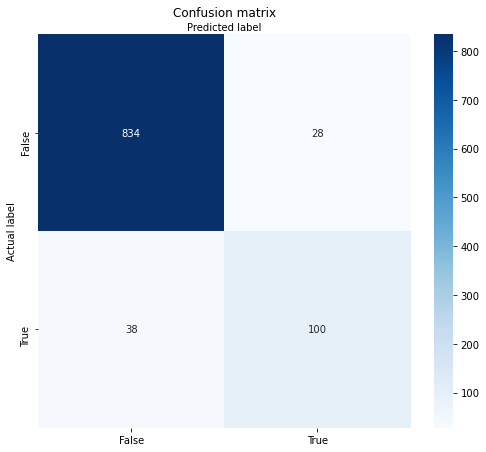

In [7]:
# Extract the best decision forest 
best_clf = grid_results.best_estimator_
y_pred = best_clf.predict(x_test)

# Create a confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap from the confusion matrix
class_names=[False, True] 
tick_marks = [0.5, 1.5]
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)

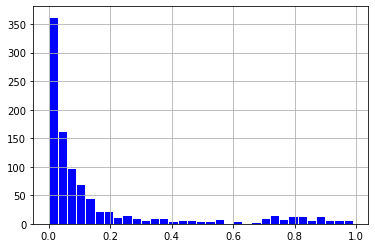

In [75]:
# Predicting Probabilities
y_pred_prob = best_clf.predict_proba(x_test) 
churnproba = y_pred_prob[:,1]

# Create histograms for feature columns separated by prediction label value
register_matplotlib_converters()
plt.hist(churnproba, color='blue', label='Churn', bins='auto', edgecolor='w')

plt.grid()                        
plt.show()

# Step #6 Best Model Permutation Feature Importance

Text(0.5, 1.0, 'Random Forest Feature Importances')

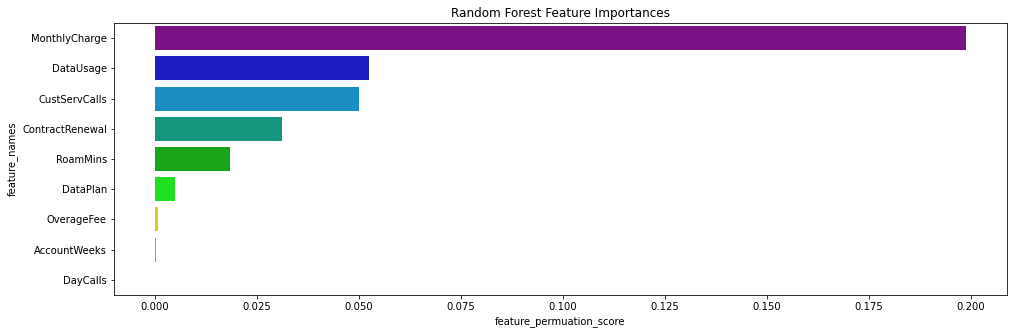

In [132]:
# Load the data
r = permutation_importance(best_clf, x_test, y_test, n_repeats=30, random_state=0)

# Set the color range
clist = [(0, "purple"), (1, "blue")]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)
colors = rvb(data_im['feature_permuation_score']/len(x_test.columns))

# Plot the barchart
data_im = pd.DataFrame(r.importances_mean, columns=['feature_permuation_score'])
data_im['feature_names'] = x_test.columns
data_im = data_im.sort_values('feature_permuation_score', ascending=False)

fig, ax = plt.subplots(figsize=(16, 5))
sns.barplot(y=data_im['feature_names'], x="feature_permuation_score", data=data_im, palette='nipy_spectral')
ax.set_title("Random Forest Feature Importances")